In [465]:
#Load Packages
import glob
import pandas as pd
import re
import numpy as np
from plotnine import *
import warnings

In [603]:
warnings.filterwarnings('ignore')

In [619]:
#RDQ
rdqPre = pd.read_spss('../Data/PrePostMeasures/RDQPre_1.sav')
rdqPost = pd.read_spss('../Data/PrePostMeasures/RDQPost_1.sav')
rdqPre

#Satisfaction
satOld = pd.read_spss('../Data/PHPSatisfaction/EndofTreatmentSurveyData/EOT Verfication_1.sav')
satNew = pd.read_spss('../Data/DischargePacket/2022-06-06 dc.sav')

#Diagnosis
dx = pd.read_spss('../Data/DemosDx/Diagnosis_1.sav')
demo = pd.read_spss('../Data/DemosDx/Demographics Form_1.sav')

In [620]:
#RDQ Arrangement: Symptoms, Coping Ability, Positive Mental Health, Functioning, Well-Being and Life Satisfaction
rdqPre.ID1 = rdqPre.ID1.astype('object')
rdqPost.ID1 = rdqPost.ID1.astype('object')
rdqPre = rdqPre.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})
rdqPost = rdqPost.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})

#Convert reverse items
for i in [29,30,48,49,50] :
    colname1 = 'rdqpre_' + str(i) + '_1'
    colname2 = 'rdqpost_' + str(i) + '_1'
    rdqPre[colname1] = abs(rdqPre[colname1].astype('float') - 2)
    rdqPost[colname2] = abs(rdqPost[colname2].astype('float') - 2)

In [606]:
rdqPre['rdqpre_29_1'] = abs(rdqPre['rdqpre_29_1'].astype('float') - 2)
rdqPre['rdqpre_30_1'] = abs(rdqPre['rdqpre_30_1'].astype('float') - 2)
rdqPre['rdqpre_48_1'] = abs(rdqPre['rdqpre_48_1'].astype('float') - 2)
rdqPre['rdqpre_49_1'] = abs(rdqPre['rdqpre_49_1'].astype('float') - 2)
rdqPre['rdqpre_50_1'] = abs(rdqPre['rdqpre_50_1'].astype('float') - 2)
rdqPre['rdqpre_51_1'] = abs(rdqPre['rdqpre_51_1'].astype('float') - 2)
rdqPre['rdqpre_52_1'] = abs(rdqPre['rdqpre_52_1'].astype('float') - 2)

rdqPost['rdqpost_29_1'] = abs(rdqPost['rdqpost_29_1'].astype('float') - 2)
rdqPost['rdqpost_30_1'] = abs(rdqPost['rdqpost_30_1'].astype('float') - 2)
rdqPost['rdqpost_48_1'] = abs(rdqPost['rdqpost_48_1'].astype('float') - 2)
rdqPost['rdqpost_49_1'] = abs(rdqPost['rdqpost_49_1'].astype('float') - 2)
rdqPost['rdqpost_50_1'] = abs(rdqPost['rdqpost_50_1'].astype('float') - 2)
rdqPost['rdqpost_51_1'] = abs(rdqPost['rdqpost_51_1'].astype('float') - 2)
rdqPost['rdqpost_52_1'] = abs(rdqPost['rdqpost_52_1'].astype('float') - 2)

In [621]:
#Agregate scores of different RDQ sections
rdqPre['pre_sym'] = rdqPre.iloc[:,1:26].mean(axis = 1)
rdqPre['pre_cope'] = rdqPre.iloc[:,26:31].mean(axis = 1)
rdqPre['pre_pmh'] = rdqPre.iloc[:,31:43].mean(axis = 1)
rdqPre['pre_fun'] = rdqPre.iloc[:,43:53].mean(axis = 1)
rdqPre['pre_well'] = rdqPre.iloc[:,53:61].mean(axis = 1)

rdqPost['post_sym'] = rdqPost.iloc[:,1:26].mean(axis = 1)
rdqPost['post_cope'] = rdqPost.iloc[:,26:31].mean(axis = 1)
rdqPost['post_pmh'] = rdqPost.iloc[:,31:43].mean(axis = 1)
rdqPost['post_fun'] = rdqPost.iloc[:,43:53].mean(axis = 1)
rdqPost['post_well'] = rdqPost.iloc[:,53:61].mean(axis = 1)

rdq = pd.merge(rdqPre, rdqPost, on = 'ID1', how = 'inner')

In [622]:
#Merge old and new overall satisfaction 
satGlobalOld = satOld.loc[:,['PHP_ID_1','OVERALL_1', 'IMPRV_1']].rename(columns = {'PHP_ID_1': 'ID1', 'OVERALL_1': 'overall1',
                                                                                   'IMPRV_1': 'imprv1'})
satGlobalNew = satNew.loc[:,['id1','overall_1', 'imprv_1']].rename(columns = {'id1': 'ID1', 'overall_1': 'overall1',
                                                                              'imprv_1': 'imprv1'})
satGlobal = pd.concat([satGlobalOld, satGlobalNew],axis = 0)
satGlobal = satGlobal[satGlobal.ID1 != 0]
satGlobal.ID1 = satGlobal.ID1.astype('object')

print('N of people who were administered with the discharge package:', satGlobal.shape[0]) 

N of people who were administered with the discharge package: 3811


In [623]:
print('Overall Satisfaction Missing Values = ', sum(satGlobal.overall1.isnull()),'\n'
      'Overall Improvement Missing Values = ', sum(satGlobal.imprv1.isnull()))

Overall Satisfaction Missing Values =  49 
Overall Improvement Missing Values =  46


In [624]:
df = pd.merge(satGlobal, rdq, how = 'inner', on = 'ID1')
df = pd.merge(df, dx, how = 'left', on = 'ID1')
df = pd.merge(df, demo, how = 'left', on = 'ID1')

In [625]:
df = df[df.filter(regex='rdqpre').isnull().sum(axis=1) <=10]
df = df[df.filter(regex='rdqpost').isnull().sum(axis=1) <=10]
print('People who completed the program and have less than 10 missing values in RDQ at intake and discharge', 
      df.shape[0])

People who completed the program and have less than 10 missing values in RDQ at intake and discharge 2711


In [626]:
df_long0 = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long0 = \
pd.melt(df_long0, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long0.rdqvar = df_long0.rdqvar.astype('category').cat.reorder_categories(
    ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'])
df_long0.satvar = df_long0.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


df_long = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')
df_long = \
pd.melt(df_long, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long.rdqvar = df_long.rdqvar.astype('category').cat.reorder_categories(
    ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'])
df_long.satvar = df_long.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


#Compute Change Score (Larger scale = Larger Improvement)
df['change_sym'] = df.pre_sym - df.post_sym 
df['change_cope'] = df.post_cope - df.pre_cope
df['change_pmh'] = df.post_pmh - df.pre_pmh
df['change_fun'] = df.post_fun - df.pre_fun
df['change_well'] = df.post_well - df.pre_well

df_long2 = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long2 = \
pd.melt(df_long2, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long2.rdqvar = df_long2.rdqvar.astype('category').cat.reorder_categories(
    ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'])
df_long2.satvar = df_long2.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])

In [637]:
df[['overall1', 'imprv1', 'pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well']].corr()

,overall1,imprv1,pre_sym,pre_cope,pre_pmh,pre_fun,pre_well
overall1,1.000000,0.557869,-0.021413,0.025154,0.030022,0.016710,0.041632
imprv1,0.557869,1.000000,-0.097867,0.095942,0.158059,0.104911,0.135814
pre_sym,-0.021413,-0.097867,1.000000,-0.484959,-0.535086,-0.371841,-0.494452
pre_cope,0.025154,0.095942,-0.484959,1.000000,0.547704,0.432347,0.499837
pre_pmh,0.030022,0.158059,-0.535086,0.547704,1.000000,0.529910,0.756277
pre_fun,0.016710,0.104911,-0.371841,0.432347,0.529910,1.000000,0.543345
pre_well,0.041632,0.135814,-0.494452,0.499837,0.756277,0.543345,1.000000


In [636]:
df[['overall1', 'imprv1', 'post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well']].corr()

,overall1,imprv1,post_sym,post_cope,post_pmh,post_fun,post_well
overall1,1.000000,0.557869,-0.232156,0.222340,0.277009,0.206637,0.262392
imprv1,0.557869,1.000000,-0.457884,0.469925,0.552663,0.403822,0.532114
post_sym,-0.232156,-0.457884,1.000000,-0.687098,-0.687886,-0.567541,-0.675026
post_cope,0.222340,0.469925,-0.687098,1.000000,0.700477,0.626250,0.700857
post_pmh,0.277009,0.552663,-0.687886,0.700477,1.000000,0.688064,0.866689
post_fun,0.206637,0.403822,-0.567541,0.626250,0.688064,1.000000,0.716190
post_well,0.262392,0.532114,-0.675026,0.700857,0.866689,0.716190,1.000000


In [646]:
#Means of change scores
df[['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].mean(axis = 0)

change_sym     0.527292
change_cope    0.500564
change_pmh     0.552289
change_fun     0.256588
change_well    0.585467
dtype: float64

In [635]:
df[['overall1', 'imprv1', 'change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].corr()

,overall1,imprv1,change_sym,change_cope,change_pmh,change_fun,change_well
overall1,1.000000,0.557869,0.218829,0.176180,0.243768,0.167538,0.216945
imprv1,0.557869,1.000000,0.383187,0.335784,0.407886,0.268585,0.401322
change_sym,0.218829,0.383187,1.000000,0.529319,0.635684,0.454096,0.585998
change_cope,0.176180,0.335784,0.529319,1.000000,0.576605,0.472089,0.568636
change_pmh,0.243768,0.407886,0.635684,0.576605,1.000000,0.581542,0.763486
change_fun,0.167538,0.268585,0.454096,0.472089,0.581542,1.000000,0.606388
change_well,0.216945,0.401322,0.585998,0.568636,0.763486,0.606388,1.000000


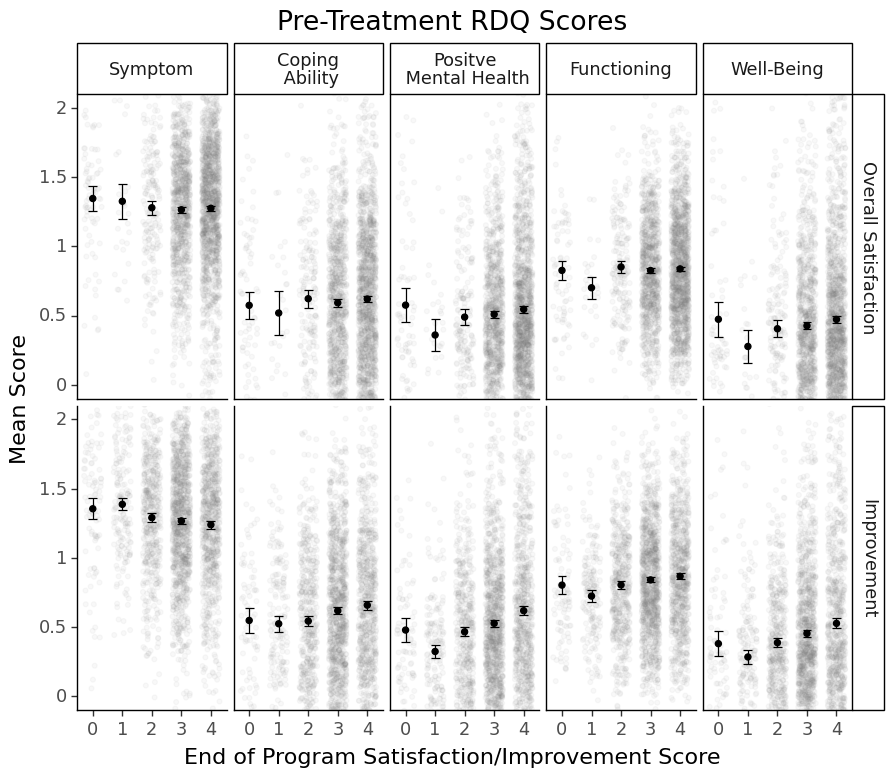

<ggplot: (8790370801674)>

In [642]:
def facet_label(s):
    if 'sym' in s: return('Symptom')
    if 'cope' in s: return ('Coping\n Ability')
    if 'pmh' in s: return('Positve\n Mental Health')
    if 'fun' in s: return ('Functioning')
    if 'well' in s: return('Well-Being')
    if 'overall' in s: return('Overall Satisfaction')
    if 'imprv' in s: return('Improvement')
    
ggplot(df_long0, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Pre-Treatment RDQ Scores')


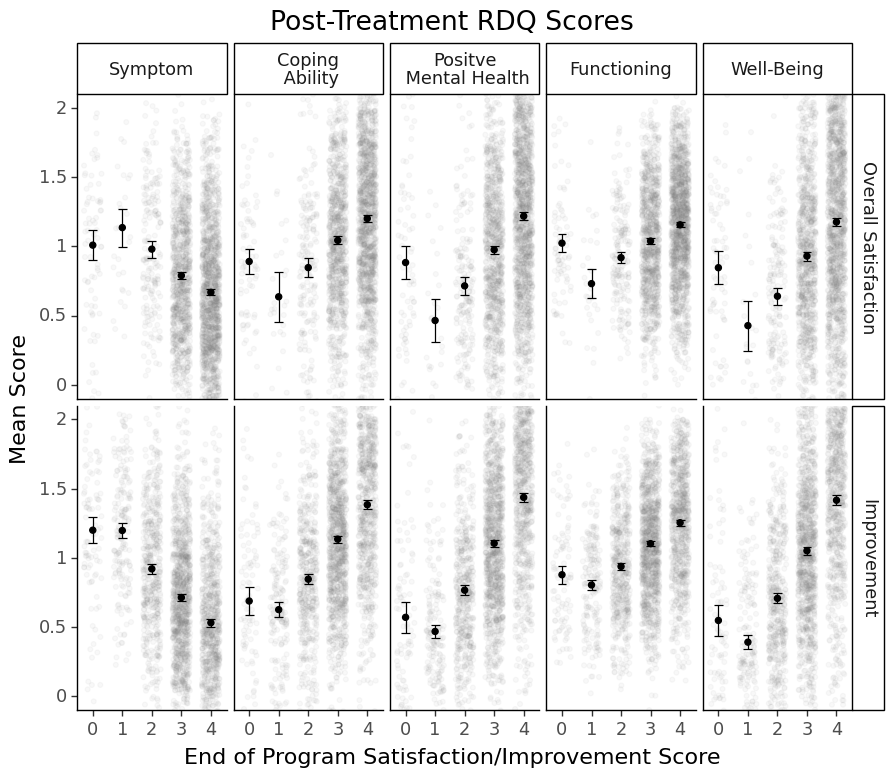

<ggplot: (8790369126066)>

In [641]:
ggplot(df_long, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Post-Treatment RDQ Scores')

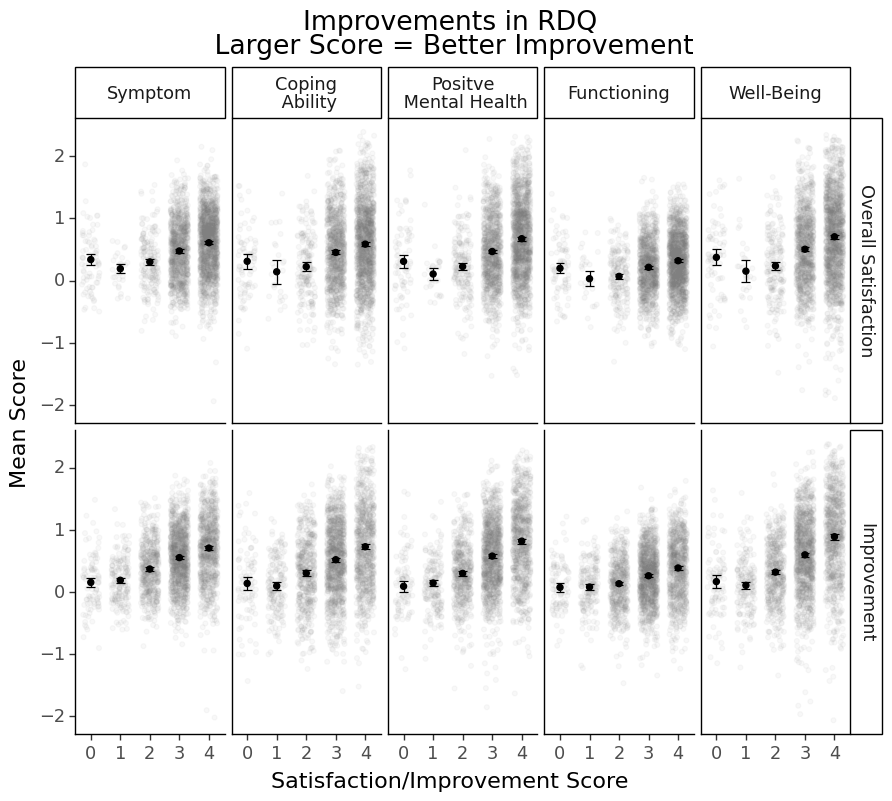

<ggplot: (8790371647492)>

In [643]:
ggplot(df_long2, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     xlab('Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Improvements in RDQ\n Larger Score = Better Improvement')